# Fishing Effort Globally

In [4]:
from math import radians, cos, sin, asin, sqrt
import matplotlib
%matplotlib inline
from matplotlib import colors,colorbar
from matplotlib.patches import PathPatch,Polygon
from matplotlib.path import Path
from mpl_toolkits.basemap import Basemap
from numpy import asarray, concatenate, ones
from shapely.geometry import Polygon, MultiPolygon, shape
from shapely.ops import transform
import bq  
import csv 
import fiona
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import time

client = bq.Client.Get()

In [2]:
# create a bounding box:
max_lat = 80
min_lat = -80
max_lon = 180
min_lon = -180

In [3]:
def Query(q):
    t0 = time.time()
    answer = client.ReadTableRows(client.Query(q)['configuration']['query']['destinationTable'])
    print 'Query time: ' + str(time.time() - t0) + ' seconds.'
    return answer

In [71]:
def draw_screen_poly( outside_ring, m, color, linewidth, opacity):
    lons = []
    lats = []
    for point in outside_ring:
        lats.append(point[1])
        l = point[0]
        lons.append(l)
        
        x, y = m( lons, lats )
        xy = zip(x,y)
        poly = Polygon( xy, facecolor=color,fill=False, alpha=1,lw=1.5, edgecolor="#222222" ,zorder=10)
        plt.gca().add_patch(poly)

In [72]:
def makeMap(grid,fig_title,fig_min_value,fig_max_value):
    plt.figure(figsize=(12, 8)) 
    ax = plt.subplot(111)
    
    firstlat = max_lat
    lastlat =  min_lat
    firstlon = min_lon
    lastlon = max_lon
    scale = cellsize

    numlats = int((firstlat-lastlat)/scale+.5)
    numlons = int((lastlon-firstlon)/scale+.5)

    lat_boxes = np.linspace(lastlat,firstlat,num=numlats,endpoint=False)
    lon_boxes = np.linspace(firstlon,lastlon,num=numlons,endpoint=False)

    extra = 0
    m = Basemap(llcrnrlat=lastlat-extra, urcrnrlat=firstlat+extra,
              llcrnrlon=firstlon-extra, urcrnrlon=lastlon+extra, lat_ts=0, projection='mill',resolution="h")

    m.drawmapboundary()#fill_color='#111111')
#     m.drawcoastlines(linewidth=.2)
    m.fillcontinents('#cccccc',lake_color='#cccccc')#, lake_color, ax, zorder, alpha)

    x = np.linspace(firstlon, lastlon, -(firstlon-lastlon)*one_over_cellsize+1)
    y = np.linspace(lastlat, firstlat, (firstlat-lastlat)*one_over_cellsize+1)
    x, y = np.meshgrid(x, y)
    converted_x, converted_y = m(x, y)
    from matplotlib import colors,colorbar

    maximum = fig_max_value # grid.max()
    minimum = fig_min_value #1

    norm = colors.LogNorm(vmin=minimum, vmax=maximum)
    # norm = colors.Normalize(vmin=0, vmax=1000)

    m.pcolormesh(converted_x, converted_y, grid, norm=norm, vmin=minimum, vmax=maximum, cmap = plt.get_cmap('viridis'))

    t = fig_title
    plt.title(t, color = "#000000", fontsize=18)

    

    theShapes = fiona.open('../../data/geospatial/World_EEZ_v8_20140228_LR/World_EEZ_v8_2014.shp')

    for p in theShapes:
        geo = p['geometry']
        sh = transform(m, shape(geo)) #transform the object to the projected map
        if geo['type'] == 'Polygon':
            draw_poly(sh)
        elif geo['type'] == 'MultiPolygon':
            for p in sh:
                draw_poly(p) 
    
    ax = fig.add_axes([0.2, 0.1, 0.65, 0.02]) #x coordinate , 
    norm = colors.LogNorm(vmin=minimum, vmax=maximum)
    # norm = colors.Normalize(vmin=0, vmax=1000)
    lvls = np.logspace(np.log10(minimum),np.log10(maximum),num=7)
    cb = colorbar.ColorbarBase(ax,norm = norm, orientation='horizontal', ticks=lvls, cmap = plt.get_cmap('viridis'))

    #cb.ax.set_xticklabels(["0" ,round(m3**.5,1), m3, round(m3**1.5,1), m3*m3,round(m3**2.5,1), str(round(m3**3,1))+"+"], fontsize=10)
    cb.ax.set_xticklabels([int(i) for i in lvls], fontsize=10, color = "#000000")
    cb.set_label('Fishing Hours per Quarter Degree Square',labelpad=-40, y=0.45, color = "#000000")
    plt.savefig(fig_title+".png",bbox_inches='tight',dpi=300,transparent=True,pad_inches=.1)
    plt.show()

# Map the Fishing Effort in The High Seas

In [74]:
# Map Fishing in High Seas
q = '''
SELECT
  INTEGER(floor(lat*4)) lat_bin,
  INTEGER(floor(lon*4)) lon_bin,
  SUM(hours) hours
FROM
  (select lat, lon, hours, measure_new_score, seg_id, eez, mmsi from
  TABLE_DATE_RANGE([pipeline_classify_logistic_715_fishing.], TIMESTAMP("2015-01-01"), TIMESTAMP("2015-12-31"))
WHERE
       lat > '''+str(min_lat)+'''
       AND lat <'''+str(max_lat)+'''
       AND lon > '''+str(min_lon)+'''
       AND lon < '''+str(max_lon)+'''
  AND measure_new_score >=.5) where 
       seg_id NOT IN ( // eliminate clearly bad segments
  SELECT
    seg_id
  FROM
    [scratch_david_seg_analysis_715.2015_segments]
  WHERE
    (point_count<20
      AND terrestrial_positions = point_count)
    OR ((min_lon >= 0 // these are almost definitely noise
        AND max_lon <= 0.109225)
      OR (min_lat >= 0
        AND max_lat <= 0.109225) ))
      and mmsi not in (412437961,412437962,412420502,412420503,412420576,412420574,412420789,412420871,
      900025357,900025393,413322650,414203586,412211196,412440255,412440256,412440257,412440258,412440259,
      412440261,150200162,412440077,412440078,412420805,412420421,412440377,412425706,412447093,412211691,
      412420276,412420917,411041815, 525018188, 412420276,412420561,533180156)
  and ( eez is null or eez = 'EEZ:Antarctica')
GROUP BY
  lat_bin,
  lon_bin
'''
# print q
fishing_grid = Query(q)

Waiting on bqjob_r6776076538b67b5d_00000156299226e2_8 ... (23s) Current status: DONE   
Query time: 41.2567980289 seconds.


In [75]:
cellsize = .25
one_over_cellsize = 4

num_lats = (max_lat-min_lat)*one_over_cellsize+1
num_lons = (max_lon-min_lon)*one_over_cellsize+1


grid = np.zeros(shape=(num_lats,num_lons))

for row in fishing_grid:
    lat = int(row[0])
    lon = int(row[1])
    lat_index = lat-min_lat*one_over_cellsize
    lon_index = lon-min_lon*one_over_cellsize
    grid[lat_index][lon_index] = float(row[2])

In [5]:
# Map Fishing Eve
q = '''
SELECT
  INTEGER(floor(lat*4)) lat_bin,
  INTEGER(floor(lon*4)) lon_bin,
  SUM(hours) hours
FROM
  (select lat, lon, hours, measure_new_score, seg_id, eez, mmsi from
  TABLE_DATE_RANGE([pipeline_classify_logistic_715_fishing.], TIMESTAMP("2015-01-01"), TIMESTAMP("2015-12-31"))
WHERE
       lat > '''+str(min_lat)+'''
       AND lat <'''+str(max_lat)+'''
       AND lon > '''+str(min_lon)+'''
       AND lon < '''+str(max_lon)+'''
       and measure_new_score > .5) 
       where 
       seg_id NOT IN ( // eliminate clearly bad segments
  SELECT
    seg_id
  FROM
    [scratch_david_seg_analysis_715.2015_segments]
  WHERE
    (point_count<20
      AND terrestrial_positions = point_count)
    OR ((min_lon >= 0 // these are almost definitely noise
        AND max_lon <= 0.109225)
      OR (min_lat >= 0
        AND max_lat <= 0.109225) ))
      and mmsi not in (412437961,412437962,412420502,412420503,412420576,412420574,412420789,412420871,
      900025357,900025393,413322650,414203586,412211196,412440255,412440256,412440257,412440258,412440259,
      412440261,150200162,412440077,412440078,412420805,412420421,412440377,412425706,412447093,412211691,
      412420276,412420917,411041815, 525018188, 412420276,412420561,533180156)
GROUP BY
  lat_bin,
  lon_bin
'''
# print q
fishing_grid_all = Query(q)

cellsize = .25
one_over_cellsize = 4

num_lats = (max_lat-min_lat)*one_over_cellsize+1
num_lons = (max_lon-min_lon)*one_over_cellsize+1

grid_all = np.zeros(shape=(num_lats,num_lons))

for row in fishing_grid_all:
    lat = int(row[0])
    lon = int(row[1])
    lat_index = lat-min_lat*one_over_cellsize
    lon_index = lon-min_lon*one_over_cellsize
    grid_all[lat_index][lon_index] = float(row[2])

Waiting on bqjob_r4475815fd8165119_00000156523e6c48_1 ... (40s) Current status: DONE   
Query time: 70.1353068352 seconds.


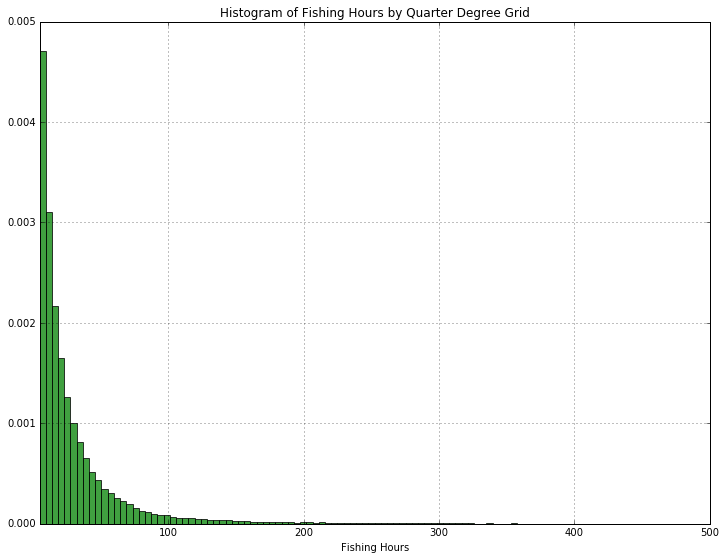

In [27]:
grid2 = np.copy(grid).flatten()
# grid2[grid2 == 0] = np.nan
# the histogram of the data
n, bins, patches = plt.hist(np.log(grid2), 3000, normed=1, facecolor='green', alpha=0.75)

# add a 'best fit' line
# y = mlab.normpdf( bins, mu, sigma)
# l = plt.plot(bins, y, 'r--', linewidth=1)

plt.xlabel('Fishing Hours')
plt.ylabel('')
plt.title(r'Histogram of Fishing Hours by Quarter Degree Grid')
plt.axis([5, 1000, 0, 0.005])
plt.grid(True)

plt.show()

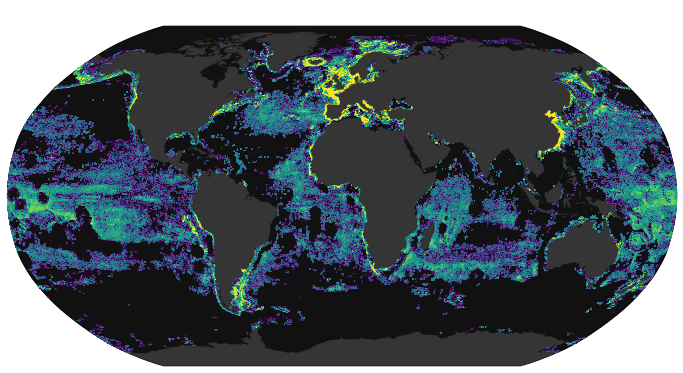

In [132]:
# makeMap(grid,"Fishing Effort in the High Seas, 2015",1,1000)
fig_title = "Fishing Effort in the High Seas, 2015" 
file_name = 'all2'
fig_min_value = 1
fig_max_value = 1000

# plt.figure(figsize=(12, 8)) 
fig, [ax1, ax2] = plt.subplots(2,1,figsize=(12,8))



firstlat = max_lat
lastlat =  min_lat
firstlon = min_lon
lastlon = max_lon
scale = cellsize

numlats = int((firstlat-lastlat)/scale+.5)
numlons = int((lastlon-firstlon)/scale+.5)

lat_boxes = np.linspace(lastlat,firstlat,num=numlats,endpoint=False)
lon_boxes = np.linspace(firstlon,lastlon,num=numlons,endpoint=False)

m = Basemap(llcrnrlat=lastlat, urcrnrlat=firstlat,
          llcrnrlon=lastlon, urcrnrlon=firstlon, lat_ts=0, projection='robin',resolution="h", lon_0=0)

m.drawmapboundary(fill_color='#111111')
m.fillcontinents('#353535',lake_color='#353535')#, lake_color, ax, zorder, alpha)

x = np.linspace(firstlon, lastlon, -(firstlon-lastlon)*one_over_cellsize+1)
y = np.linspace(lastlat, firstlat, (firstlat-lastlat)*one_over_cellsize+1)
x, y = np.meshgrid(x, y)
converted_x, converted_y = m(x, y)

maximum = fig_max_value # grid.max()
minimum = fig_min_value #1

norm = colors.LogNorm(vmin=fig_min_value, vmax=fig_max_value)

m.pcolormesh(converted_x, converted_y, grid_all, norm=norm, vmin=fig_min_value,
             vmax=fig_max_value, cmap = plt.get_cmap('viridis'))

plt.title(fig_title, color = "#ffffff", fontsize=18)

# world = shape({"type": "Polygon", "coordinates": [[[-180,-90],[-180,90],[180,90],[180,-90],[-180,-90]]]})
# theShapes = fiona.open('../../data/geospatial/World_EEZ_v8_20140228_LR/World_EEZ_v8_2014.shp')
# for p in theShapes:
#     geo = p['geometry']
#     geom = shape(geo)
#     geom = geom.intersection(world)
#     sh = transform(m, geom) #transform the object to the projected map
#     if geo['type'] == 'Polygon':
#         draw_poly(sh)
#     elif geo['type'] == 'MultiPolygon':
#         for p in sh:
#             draw_poly(p) 
            
ax = fig.add_axes([0.2, 0.1, 0.65, 0.02]) #x coordinate , 
norm = colors.LogNorm(vmin=minimum, vmax=maximum)
lvls = np.logspace(np.log10(minimum),np.log10(maximum),num=7)
cb = colorbar.ColorbarBase(ax,norm = norm, orientation='horizontal', ticks=lvls, cmap = plt.get_cmap('viridis'))
cb.ax.set_xticklabels([int(i) for i in lvls], fontsize=10, color = "#000000")
cb.set_label('Fishing Hours per Quarter Degree Square',labelpad=-40, y=0.45, color = "#000000")
plt.savefig(file_name+".png",bbox_inches='tight',dpi=300,transparent=True,pad_inches=.1, facecolor="#000000")
plt.show()

NameError: name 'world' is not defined

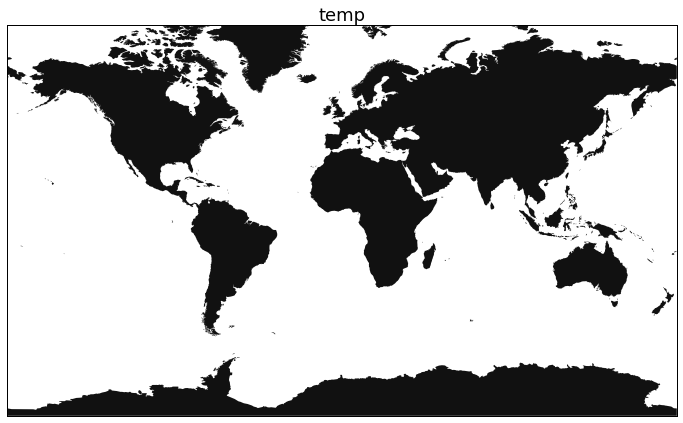

In [31]:
plt.figure(figsize=(12, 8)) 
ax = plt.subplot(111)

firstlat = max_lat
lastlat =  min_lat
firstlon = min_lon
lastlon = max_lon
scale = cellsize

numlats = int((firstlat-lastlat)/scale+.5)
numlons = int((lastlon-firstlon)/scale+.5)

lat_boxes = np.linspace(lastlat,firstlat,num=numlats,endpoint=False)
lon_boxes = np.linspace(firstlon,lastlon,num=numlons,endpoint=False)

extra = 0
m = Basemap(llcrnrlat=lastlat-extra, urcrnrlat=firstlat+extra,
          llcrnrlon=firstlon-extra, urcrnrlon=lastlon+extra, lat_ts=0, projection='mill',resolution="l")

m.drawmapboundary()#fill_color='#111111')
#     m.drawcoastlines(linewidth=.2)
m.fillcontinents('#111111',lake_color='#111111')#, lake_color, ax, zorder, alpha)

plt.title("temp", color = "#000000", fontsize=18)


theShapes = fiona.open('../../data/geospatial/World_EEZ_v8_20140228_LR/World_EEZ_v8_2014.shp')
    
for p in theShapes:
    geo = p['geometry']
    geom = shape(geo)
    geom = geom.intersection(world)
    sh = transform(m, geom) #transform the object to the projected map
    if geo['type'] == 'Polygon':
        draw_poly(sh,ax)
    elif geo['type'] == 'MultiPolygon':
        for p in sh:
            draw_poly(p,ax) 


# plt.savefig(fig_title+".png",bbox_inches='tight',dpi=300,transparent=True,pad_inches=.1)
plt.show()

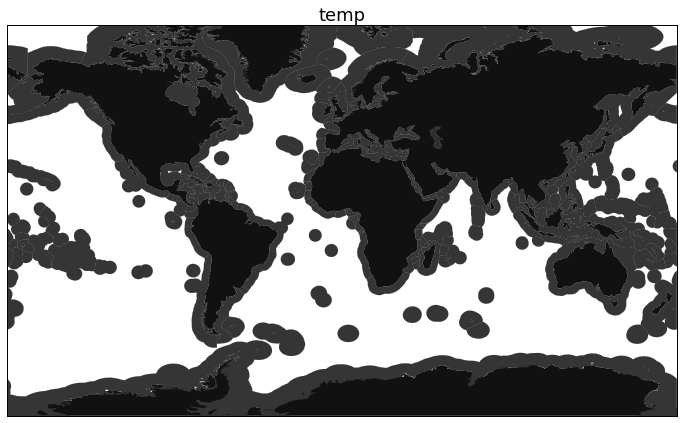

In [15]:
plt.figure(figsize=(12, 8)) 
ax = plt.subplot(111)

firstlat = max_lat
lastlat =  min_lat
firstlon = min_lon
lastlon = max_lon
scale = cellsize

numlats = int((firstlat-lastlat)/scale+.5)
numlons = int((lastlon-firstlon)/scale+.5)

lat_boxes = np.linspace(lastlat,firstlat,num=numlats,endpoint=False)
lon_boxes = np.linspace(firstlon,lastlon,num=numlons,endpoint=False)

lon_adjust = 0
m = Basemap(llcrnrlat=lastlat, urcrnrlat=firstlat,
          llcrnrlon=firstlon+lon_adjust, urcrnrlon=lastlon+lon_adjust, lat_ts=0, projection='mill',resolution="l")

m.drawmapboundary()
m.fillcontinents('#111111',lake_color='#111111')#, lake_color, ax, zorder, alpha)

plt.title("temp", color = "#000000", fontsize=18)


theShapes = fiona.open('../../data/geospatial/World_EEZ_v8_20140228_LR/World_EEZ_v8_2014.shp')
    
for p in theShapes:
    geo = p['geometry']
    geom = shape(geo)
#     geom = geom.intersection(world)
    sh = transform(m, geom) #transform the object to the projected map
    if geo['type'] == 'Polygon':
        draw_poly(sh)
    elif geo['type'] == 'MultiPolygon':
        for p in sh:
            draw_poly(p) 


# plt.savefig(fig_title+".png",bbox_inches='tight',dpi=300,transparent=True,pad_inches=.1)
plt.show()

In [27]:
'''Make a custom colormap'''

tm = 255
thecolors = [['#FDD0BD',0,0], # a small vaiation on 'Reds' colormap
          ['#620110',255,255]]
cdict = { 'red':tuple(   (color[2]/tm, int(color[0][1:3],16)/256.0, int(color[0][1:3],16)/256.0) for color in thecolors ),
      'green':tuple( (color[2]/tm, int(color[0][3:5],16)/256.0, int(color[0][3:5],16)/256.0) for color in thecolors ),
      'blue':tuple(  (color[2]/tm, int(color[0][5:7],16)/256.0, int(color[0][5:7],16)/256.0) for color in thecolors )}

mycmap = colors.LinearSegmentedColormap('my_colormap',cdict,256)


thecolors = [['#FDD0BD',0,0], # a small vaiation on 'Reds' colormap
          ['#62000C',255,255]]
cdict = { 'red':tuple(   (color[2]/tm, int(color[0][1:3],16)/256.0, int(color[0][1:3],16)/256.0) for color in thecolors ),
      'green':tuple( (color[2]/tm, int(color[0][3:5],16)/256.0, int(color[0][3:5],16)/256.0) for color in thecolors ),
      'blue':tuple(  (color[2]/tm, int(color[0][5:7],16)/256.0, int(color[0][5:7],16)/256.0) for color in thecolors )}

mycmap_redder = colors.LinearSegmentedColormap('my_colormap',cdict,256)


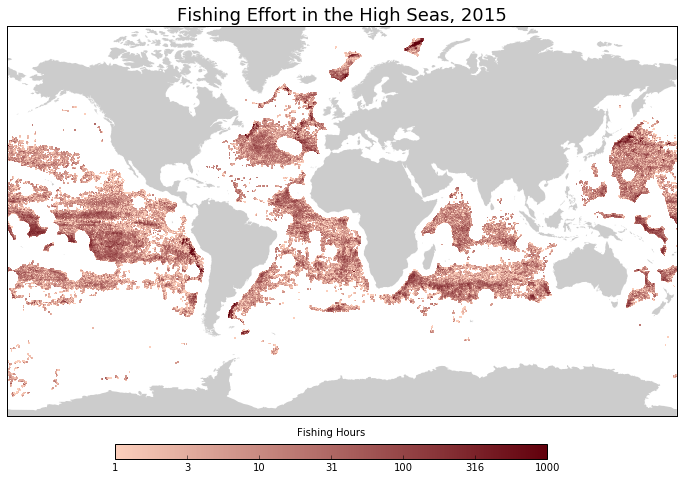

In [38]:

fig_min_value = 1
fig_max_value = 1000
lon_adjust = 0
x = np.linspace(firstlon+lon_adjust, lastlon+lon_adjust, -(firstlon-lastlon)*one_over_cellsize+1)
y = np.linspace(lastlat, firstlat, (firstlat-lastlat)*one_over_cellsize+1)
x, y = np.meshgrid(x, y)
lat_boxes = np.linspace(lastlat,firstlat,num=numlats,endpoint=False)
lon_boxes = np.linspace(firstlon+lon_adjust,lastlon+lon_adjust,num=numlons,endpoint=False)

# offset_grid = np.zeros((numlats,numlons))

# i = 0
# pixel_offset = lon_adjust*one_over_cellsize
# offset_grid[:,0:len(grid[0]) - pixel_offset] = all_grids[i][:,pixel_offset:len(all_grids[i][0])] 
# offset_grid[:,len(all_grids[i][0]) - pixel_offset:len(all_grids[i][0])] = all_grids[i][:,0:pixel_offset]

fig = plt.figure(figsize=(12, 8))
m = Basemap(llcrnrlat=lastlat, urcrnrlat=firstlat,
          llcrnrlon=firstlon+lon_adjust, urcrnrlon=lastlon+lon_adjust, lat_ts=0, projection='mill',resolution="l")
m.drawmapboundary()#fill_color='#111111')
m.fillcontinents('#cccccc',lake_color='#cccccc')#, lake_color, ax, zorder, alpha)
converted_x, converted_y = m(x, y)
maximum = fig_max_value 
minimum = fig_min_value 
norm = colors.LogNorm(vmin=minimum, vmax=maximum)
m.pcolormesh(converted_x, converted_y, grid, norm=norm, vmin=minimum, vmax=maximum, cmap = mycmap_redder)
plt.title("Fishing Effort in the High Seas, 2015", color = "#000000", fontsize=18)

ax4 = fig.add_axes([0.25, 0.1, 0.5, 0.025]) #x coordinate ,#plt.subplot(gs[4:6])
norm = colors.LogNorm(vmin=1, vmax=1000)
lvls = np.logspace(np.log10(1),np.log10(1000),num=7)
cb = colorbar.ColorbarBase(ax4,norm = norm, orientation='horizontal',ticks=lvls, cmap = mycmap_redder)#
cb.ax.set_xticklabels([int(i) for i in lvls], fontsize=10, color = "#000000")
cb.set_label('Fishing Hours',labelpad=-45, y=0.45, color = "#000000")
plt.savefig("High_Seas_noEEZ.png",bbox_inches='tight',dpi=300,transparent=True,pad_inches=.1)

plt.show()

In [49]:
# plt.rcParams["figure.figsize"] = [12,8]

def draw_poly(poly, ax):
    path = pathify(poly)
    patch = PathPatch(path, facecolor='#000000', lw=.3, alpha = 1 ,zorder=1,fill=False) #787878
    ax.add_patch(patch)   

##########FUNCTIONS FOR DRAWING POLYGONS##########
def ring_coding(ob):
    # The codes will be all "LINETO" commands, except for "MOVETO"s at the
    # beginning of each subpath
    n = len(ob.coords)
    codes = ones(n, dtype=Path.code_type) * Path.LINETO
    codes[0] = Path.MOVETO
    return codes

def pathify(polygon):
    # Convert coordinates to path vertices. Objects produced by Shapely's
    # analytic methods have the proper coordinate order, no need to sort.
    vertices = concatenate(
                    [asarray(polygon.exterior)]
                    + [asarray(r) for r in polygon.interiors])
    codes = concatenate(
                [ring_coding(polygon.exterior)]
                + [ring_coding(r) for r in polygon.interiors])
    return Path(vertices, codes)

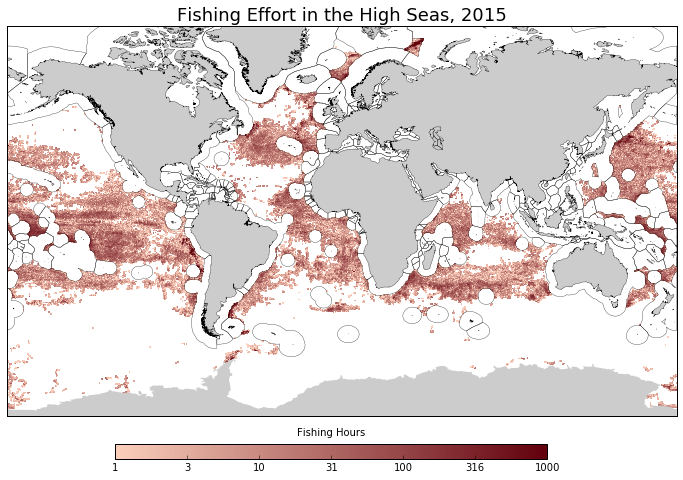

In [76]:

fig_min_value = 1
fig_max_value = 1000
lon_adjust = 0
x = np.linspace(firstlon+lon_adjust, lastlon+lon_adjust, -(firstlon-lastlon)*one_over_cellsize+1)
y = np.linspace(lastlat, firstlat, (firstlat-lastlat)*one_over_cellsize+1)
x, y = np.meshgrid(x, y)
lat_boxes = np.linspace(lastlat,firstlat,num=numlats,endpoint=False)
lon_boxes = np.linspace(firstlon+lon_adjust,lastlon+lon_adjust,num=numlons,endpoint=False)

# offset_grid = np.zeros((numlats,numlons))

# i = 0
# pixel_offset = lon_adjust*one_over_cellsize
# offset_grid[:,0:len(grid[0]) - pixel_offset] = all_grids[i][:,pixel_offset:len(all_grids[i][0])] 
# offset_grid[:,len(all_grids[i][0]) - pixel_offset:len(all_grids[i][0])] = all_grids[i][:,0:pixel_offset]

fig = plt.figure(figsize=(12, 8))
ax = plt.subplot(111)
m = Basemap(llcrnrlat=lastlat, urcrnrlat=firstlat,
          llcrnrlon=firstlon+lon_adjust, urcrnrlon=lastlon+lon_adjust, lat_ts=0, projection='mill',resolution="l")
m.drawmapboundary()#fill_color='#111111')
m.fillcontinents('#cccccc',lake_color='#cccccc')#, lake_color, ax, zorder, alpha)
converted_x, converted_y = m(x, y)
maximum = fig_max_value 
minimum = fig_min_value 
norm = colors.LogNorm(vmin=minimum, vmax=maximum)
m.pcolormesh(converted_x, converted_y, grid, norm=norm, vmin=minimum, vmax=maximum, cmap = mycmap_redder)
plt.title("Fishing Effort in the High Seas, 2015", color = "#000000", fontsize=18)

theShapes = fiona.open('../../data/geospatial/World_EEZ_v8_20140228_LR/World_EEZ_v8_2014.shp')
    
for p in theShapes:
    if p['properties']['Sovereign'] != 'Antarctica':
        geo = p['geometry']
        geom = shape(geo)
    #     geom = geom.intersection(world)
        sh = transform(m, geom) #transform the object to the projected map
        if geo['type'] == 'Polygon':
            draw_poly(sh,ax)
        elif geo['type'] == 'MultiPolygon':
            for p in sh:
                draw_poly(p,ax) 

ax4 = fig.add_axes([0.25, 0.1, 0.5, 0.025]) #x coordinate ,#plt.subplot(gs[4:6])
norm = colors.LogNorm(vmin=1, vmax=1000)
lvls = np.logspace(np.log10(1),np.log10(1000),num=7)
cb = colorbar.ColorbarBase(ax4,norm = norm, orientation='horizontal',ticks=lvls, cmap = mycmap_redder)#
cb.ax.set_xticklabels([int(i) for i in lvls], fontsize=10, color = "#000000")
cb.set_label('Fishing Hours',labelpad=-45, y=0.45, color = "#000000")
plt.savefig("High_Seas_EEZ2.png",bbox_inches='tight',dpi=300,transparent=True,pad_inches=.1)

plt.show()

In [7]:

fig_min_value = 1
fig_max_value = 10000

firstlat = max_lat
lastlat =  min_lat
firstlon = min_lon
lastlon = max_lon
scale = cellsize

the_cmap = 'vidris'

lon_adjust = 0
x = np.linspace(firstlon+lon_adjust, lastlon+lon_adjust, -(firstlon-lastlon)*one_over_cellsize+1)
y = np.linspace(lastlat, firstlat, (firstlat-lastlat)*one_over_cellsize+1)
x, y = np.meshgrid(x, y)
lat_boxes = np.linspace(lastlat,firstlat,num=numlats,endpoint=False)
lon_boxes = np.linspace(firstlon+lon_adjust,lastlon+lon_adjust,num=numlons,endpoint=False)

# offset_grid = np.zeros((numlats,numlons))

# i = 0
# pixel_offset = lon_adjust*one_over_cellsize
# offset_grid[:,0:len(grid[0]) - pixel_offset] = all_grids[i][:,pixel_offset:len(all_grids[i][0])] 
# offset_grid[:,len(all_grids[i][0]) - pixel_offset:len(all_grids[i][0])] = all_grids[i][:,0:pixel_offset]

fig = plt.figure(figsize=(12, 8))
ax = plt.subplot(111)
m = Basemap(llcrnrlat=lastlat, urcrnrlat=firstlat,
          llcrnrlon=firstlon+lon_adjust, urcrnrlon=lastlon+lon_adjust, lat_ts=0, projection='mill',resolution="l")
m.drawmapboundary()#fill_color='#111111')
m.fillcontinents('#cccccc',lake_color='#cccccc')#, lake_color, ax, zorder, alpha)
converted_x, converted_y = m(x, y)
maximum = fig_max_value 
minimum = fig_min_value 
norm = colors.LogNorm(vmin=minimum, vmax=maximum)
m.pcolormesh(converted_x, converted_y, grid_all, norm=norm, vmin=minimum, vmax=maximum, cmap = the_cmap)
plt.title("Fishing Effort in 2015", color = "#000000", fontsize=18)

# theShapes = fiona.open('../../data/geospatial/World_EEZ_v8_20140228_LR/World_EEZ_v8_2014.shp')
    
# for p in theShapes:
#     geo = p['geometry']
#     geom = shape(geo)
# #     geom = geom.intersection(world)
#     sh = transform(m, geom) #transform the object to the projected map
#     if geo['type'] == 'Polygon':
#         draw_poly(sh,ax)
#     elif geo['type'] == 'MultiPolygon':
#         for p in sh:
#             draw_poly(p,ax) 

ax4 = fig.add_axes([0.25, 0.1, 0.5, 0.025]) #x coordinate ,#plt.subplot(gs[4:6])
norm = colors.LogNorm(vmin=1, vmax=1000)
lvls = np.logspace(np.log10(1),np.log10(1000),num=7)
cb = colorbar.ColorbarBase(ax4,norm = norm, orientation='horizontal',ticks=lvls, cmap = the_cmap)#
cb.ax.set_xticklabels([int(i) for i in lvls], fontsize=10, color = "#000000")
cb.set_label('Fishing Hours',labelpad=-45, y=0.45, color = "#000000")
plt.savefig("AllFishing.png",bbox_inches='tight',dpi=300,transparent=True,pad_inches=.1)

plt.show()

NameError: name 'numlats' is not defined

In [56]:
theShapes = fiona.open('../../data/geospatial/World_EEZ_v8_20140228_LR/World_EEZ_v8_2014.shp')
    
for p in theShapes:
    geo = p['geometry']
    if p['properties']['Sovereign'] == 'Antarctica':
        print "wow"


wow
